<a href="https://colab.research.google.com/github/HS587885/Studying-MachineLearning/blob/main/cutmix_imageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip /content/drive/MyDrive/data/art_data/train.zip
!unzip /content/drive/MyDrive/data/art_data/test.zip

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 문제 해설
- 데이터의 수가 부족하다고 판단 되어 기본적인 Data Augmentation을 수행
    - brightness_range
    - horizontal_flip
    - rescale
    - Cutmix
- ImageNet 데이터 셋과 유사하다고 판단되어 Pretrain 수행
    - Xception, EfficientNetB4, EfficientNetB5, InceptionV3, InceptionResNetV2
    - 하지만 art data이므로 fc나 하위레이어 몇개를 재학습시키는 fine tuning보다는 전체 파라미터를 재학습 하는 방향으로 학습을 수행
- Predict 성능 향상을 위해 앙상블 수행
    - 개별 모델의 acc와 loss를 확인하기 위해서 각기 모델을 수행 후 weight를 load하여 prediction을 수행

## 문제 해결 방안

- 공통 파라미터
    - IMG_SIZE = 200
    - BATCH_SIZE = 20
    - CHANNEL_SIZE = 3
    - LEARNING_RATE = 1e-4
    - OPTIMIZER = optimizers.Adam(lr=LEARNING_RATE)
    - EPOCHS = 100
    - INITIALIZER = 'he_normal'
    - REGULARIZER = regularizers.l2(1e-3)
    - DROPOUT_RATE = 0.5
    - PATIENCE = 10  # Patience Value For Early Stop
    - VERBOSE = 1  # Verbosity mode (2: No progress bar)
    - CLASS_NB = len(classes) # The number of Classes
- 공통 이미지 전처리 파라미터
    - cutmix 적용
    - rotation_range=15, # 추가
    - shear_range=0.1, # 추가
    - brightness_range=(0.6, 1.4),
    - horizontal_flip=True,
    - vertical_flip=False,
    - rescale=1./255,

수행 결과
1. Xception(score = 88.57142857142857)
    - LEARNING_RATE = 1e-4
    - EPOCHS = 100
    
2. EfficientNetB4(score = 91.42857142857143)
    - LEARNING_RATE = 1e-4
    - EPOCHS = 100

3. ensmeble(score = 92.85714285714286)
    - Xception+EfficientNetB4

4. Retraining(score = 92.85714285714286)
    - Xception, EfficientNetB4 각각 재훈련
    - train data에 UnderSampling 적용
    - LEARNING_RATE = 1e-5
    - EPOCHS = 30

5. DenseNet201(score = 91.42857142857143)
    - UnderSampling은 큰 개선이 없음
    - LEARNING_RATE = 1e-4
    - EPOCHS = 100
    
6. ensmeble(score = 92.85714285714286)
    - Xception+EfficientNetB4+DenseNet201
    - 모델을 더 추가하여도 결과 개선이 없음
    
7. ensmeble(score = 94.28571428571428)
    - 전체 데이터셋으로 재 학습
    - vertical_flip=True 추가

## GPU Check

In [12]:
import tensorflow as tf
tf.__version__

'2.15.0'

In [13]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6203789315936294753
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14626652160
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 11455825907197477291
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

## Initial Settings

In [14]:
!pip install cutmix_keras

In [15]:
import gc
import os, shutil
import random
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import PIL
from PIL import ImageDraw
from tensorflow.keras import regularizers
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
import glob
from cutmix_keras import CutMixImageDataGenerator  # Import CutMix

In [16]:
# 시간 출력을 위한 함수
from datetime import datetime
from pytz import timezone, utc

KST = timezone('Asia/Seoul')

def system_print(string):
    os.system(f'echo \"{string}\"')
    print(string)

# To Add CallBack List
class PrintSystemLogPerEpoch(Callback):
    def on_epoch_begin(self, epoch, logs={}):
        t = utc.localize(datetime.utcnow()).astimezone(KST).time()
        system_print(f'* [Epoch {epoch+1}] begins at {t}')
    def on_epoch_end(self, epoch, logs={}):
        t = utc.localize(datetime.utcnow()).astimezone(KST).time()
        system_print(f'* [Epoch {epoch+1}] ends at {t} | acc={logs["acc"]:0.4f}, val_acc={logs["val_acc"]:0.4f}')

## Prepare Data
- filename과 class들을 df로 만들기 위해서 추가 처리 수행
    - 파일 앞에 class prerfix를 붙여 rename
    - file들을 다른 폴더로 copy

In [37]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

base_dir = '/content/'

origin_train_dir = os.path.join(base_dir, 'train')
class_names = os.listdir(origin_train_dir)
train_dir = os.path.join(base_dir, 'train_rename')

In [45]:
# 파일이름 rename
IS_RENAME = True

if IS_RENAME:
    for class_name in class_names:
        path = os.path.join(origin_train_dir, class_name)
        files = glob.glob(path + '/*')
        for f in files:
            os.rename(f, os.path.join(path, class_name + '_' + os.path.basename(f)))

In [ ]:
# 파일 이동
IS_COPY = True

if IS_COPY:
    for class_name in class_names:
        path = os.path.join(origin_train_dir, class_name)
        files = glob.glob(path + '/*.jpg')

        for f in files:
            print(os.path.join(path), os.path.basename(f))
            src = os.path.join((path), os.path.basename(f))
            dst = os.path.join(train_dir, os.path.basename(f))
            shutil.copyfile(src, dst)

In [51]:
classes = ['dog', 'elephant', 'giraffe','guitar','horse','house','person']
classes_dict = {i : classes[i] for i in range(len(classes))}

In [102]:
classes_dict

{0: 'dog',
 1: 'elephant',
 2: 'giraffe',
 3: 'guitar',
 4: 'horse',
 5: 'house',
 6: 'person'}

In [82]:
filenames = os.listdir(train_dir)
print(filenames)
categories = []
for filename in filenames:
    category = filename.split('_')[0]

    for i, c in enumerate(classes):
        if category == c:
            categories.append(i)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

['elephant_pic_106.jpg', 'giraffe_pic_239.jpg', 'house_pic_138.jpg', 'giraffe_pic_147.jpg', 'guitar_pic_058.jpg', 'elephant_pic_051.jpg', 'horse_pic_024.jpg', 'person_pic_082.jpg', 'person_pic_164.jpg', 'house_pic_023.jpg', 'giraffe_pic_037.jpg', 'dog_pic_010.jpg', 'guitar_pic_043.jpg', 'dog_pic_323.jpg', 'dog_pic_340.jpg', 'person_pic_135.jpg', 'giraffe_pic_234.jpg', 'house_pic_209.jpg', 'horse_pic_040.jpg', 'horse_pic_056.jpg', 'person_pic_480.jpg', 'guitar_pic_109.jpg', 'person_pic_492.jpg', 'person_pic_183.jpg', 'elephant_pic_056.jpg', 'person_pic_045.jpg', 'dog_pic_108.jpg', 'giraffe_pic_066.jpg', 'person_pic_389.jpg', 'elephant_pic_057.jpg', 'house_pic_256.jpg', 'guitar_pic_075.jpg', 'elephant_pic_185.jpg', 'dog_pic_231.jpg', 'elephant_pic_041.jpg', 'dog_pic_351.jpg', 'dog_pic_017.jpg', 'person_pic_116.jpg', 'person_pic_429.jpg', 'person_pic_215.jpg', 'house_pic_088.jpg', 'dog_pic_165.jpg', 'elephant_pic_070.jpg', 'giraffe_pic_173.jpg', 'elephant_pic_073.jpg', 'giraffe_pic_245.jp

In [53]:
df

filename  category
0     elephant_pic_106.jpg         1
1      giraffe_pic_239.jpg         2
2        house_pic_138.jpg         5
3      giraffe_pic_147.jpg         2
4       guitar_pic_058.jpg         3
...                    ...       ...
1693  elephant_pic_167.jpg         1
1694   giraffe_pic_174.jpg         2
1695       dog_pic_339.jpg         0
1696    person_pic_236.jpg         6
1697  elephant_pic_072.jpg         1

[1698 rows x 2 columns]

<Axes: >

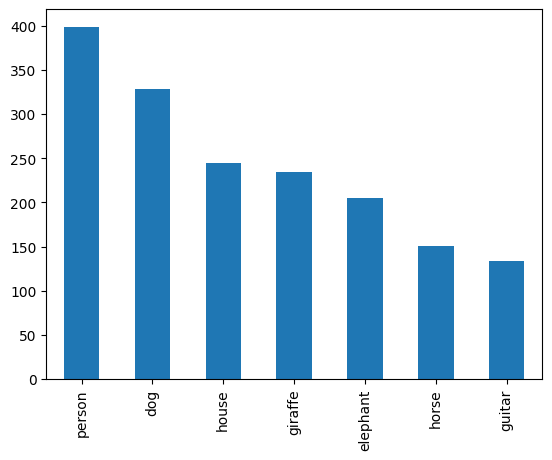

In [123]:
df["category"] = df["category"].replace(classes_dict)

df['category'].value_counts().plot.bar()

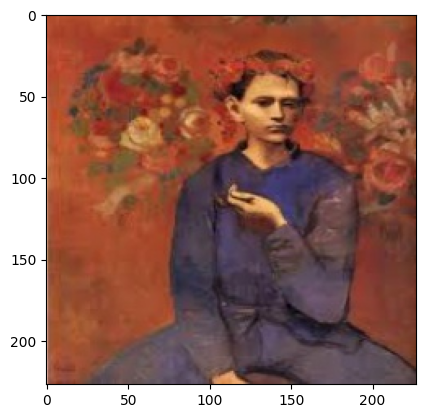

In [124]:
sample = random.choice(filenames)
image = load_img(train_dir+"/"+sample)
plt.imshow(image)

## Generator
- 모델 실행 시 OOM이 발생하여 IMG_SIZE를 (200, 200)으로 수정
- Cutmix를 활용하여 Data Augmentation시킴
    - input data의 특정 부분을 다른 input data와 결합시킴으로써, input data에 drop out을 취하는 효과를 얻음
    - 또한, 기존의 Cutout과 달리 label도 Mix가능함
    - 데이터 분류시 feature map의 더 많은 부분을 활성화 시킬 수 있음
    
- ImageDataGenerator에 옵션을 더 추가하여 돌릴 경우 너무 많이 데이터가 증가하여 속도가 느려짐

In [56]:
# imblearn 라이브러리를 임포트합니다.
import imblearn

# imblearn에서 RandomUnderSampler를 임포트합니다. 이는 무작위 언더샘플링을 수행하는 클래스입니다.
from imblearn.under_sampling import RandomUnderSampler

# 언더샘플링 전략을 정의합니다. 여기서는 RandomUnderSampler를 사용하여 클래스 간의 불균형을 줄입니다.
undersample = RandomUnderSampler(random_state=42)

# fit_resample 메소드를 사용하여 데이터의 불균형을 줄입니다.
# 이 메소드는 오버샘플링된 클래스에서 샘플을 줄여서 클래스 간의 균형을 맞춥니다.
# 'filename' 열을 특징으로, 'category' 열을 레이블로 사용하여 언더샘플링을 수행합니다.
sampling_filenames, sampling_categories = undersample.fit_resample(df[['filename']], df[['category']])


In [125]:
sampling_filenames['category'] = sampling_categories

<Axes: >

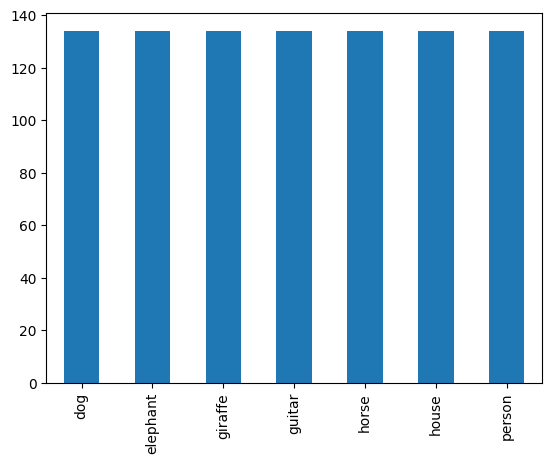

In [126]:
df_sampling = sampling_filenames.copy()
df_sampling['category'].value_counts().plot.bar()

In [127]:
from cutmix_keras import CutMixImageDataGenerator
from sklearn.model_selection import train_test_split

IMG_SIZE = 200
BATCH_SIZE = 20
CHANNEL_SIZE = 3

In [128]:
train_df, validate_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['category'])
train_df = train_df.reset_index(drop=True)
validation_df = validate_df.reset_index(drop=True)

In [129]:
df

filename  category
0     elephant_pic_106.jpg  elephant
1      giraffe_pic_239.jpg   giraffe
2        house_pic_138.jpg     house
3      giraffe_pic_147.jpg   giraffe
4       guitar_pic_058.jpg    guitar
...                    ...       ...
1693  elephant_pic_167.jpg  elephant
1694   giraffe_pic_174.jpg   giraffe
1695       dog_pic_339.jpg       dog
1696    person_pic_236.jpg    person
1697  elephant_pic_072.jpg  elephant

[1698 rows x 2 columns]

In [130]:
train_df

filename  category
0     elephant_pic_099.jpg  elephant
1        horse_pic_119.jpg     horse
2      giraffe_pic_171.jpg   giraffe
3          dog_pic_044.jpg       dog
4        house_pic_164.jpg     house
...                    ...       ...
1353       dog_pic_358.jpg       dog
1354    guitar_pic_079.jpg    guitar
1355     house_pic_003.jpg     house
1356  elephant_pic_040.jpg  elephant
1357     house_pic_178.jpg     house

[1358 rows x 2 columns]

In [131]:
validation_df

filename  category
0       house_pic_216.jpg     house
1      person_pic_167.jpg    person
2     giraffe_pic_175.jpg   giraffe
3    elephant_pic_135.jpg  elephant
4      person_pic_152.jpg    person
..                    ...       ...
335    person_pic_174.jpg    person
336     house_pic_268.jpg     house
337       dog_pic_096.jpg       dog
338   giraffe_pic_141.jpg   giraffe
339    person_pic_064.jpg    person

[340 rows x 2 columns]

In [132]:
train_df["category"].value_counts()

person      319
dog         263
house       196
giraffe     188
elephant    164
horse       121
guitar      107
Name: category, dtype: int64

In [118]:
train_df["category"].value_counts()

6    319
0    263
5    196
2    188
1    164
4    121
3    107
Name: category, dtype: int64

In [119]:
validate_df["category"].value_counts()

6    80
0    66
5    49
2    47
1    41
4    30
3    27
Name: category, dtype: int64

In [133]:
color_mode = "grayscale" if CHANNEL_SIZE == 1 else "rgb"

# train_datagen = ImageDataGenerator(
#     rotation_range=15,
#     rescale=1./255,
#     shear_range=0.1,
#     zoom_range=0.2,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     brightness_range=(0.6, 1.4),
#     horizontal_flip=True,
#     vertical_flip=False,
# )


train_datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1./255,
)

train_generator1 = train_datagen.flow_from_dataframe(
    train_df,
    #df,
    train_dir,
    x_col='filename',
    y_col='category',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    color_mode=color_mode,
    class_mode='categorical',
    shuffle=True
)

train_generator2 = train_datagen.flow_from_dataframe(
    train_df,
    #df,
    train_dir,
    x_col='filename',
    y_col='category',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    color_mode=color_mode,
    class_mode='categorical',
    shuffle=True
)

# !! Define CutMixImageDataGenerator !!
train_generator = CutMixImageDataGenerator(
    generator1=train_generator1,
    generator2=train_generator2,
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

Found 1358 validated image filenames belonging to 7 classes.
Found 1358 validated image filenames belonging to 7 classes.


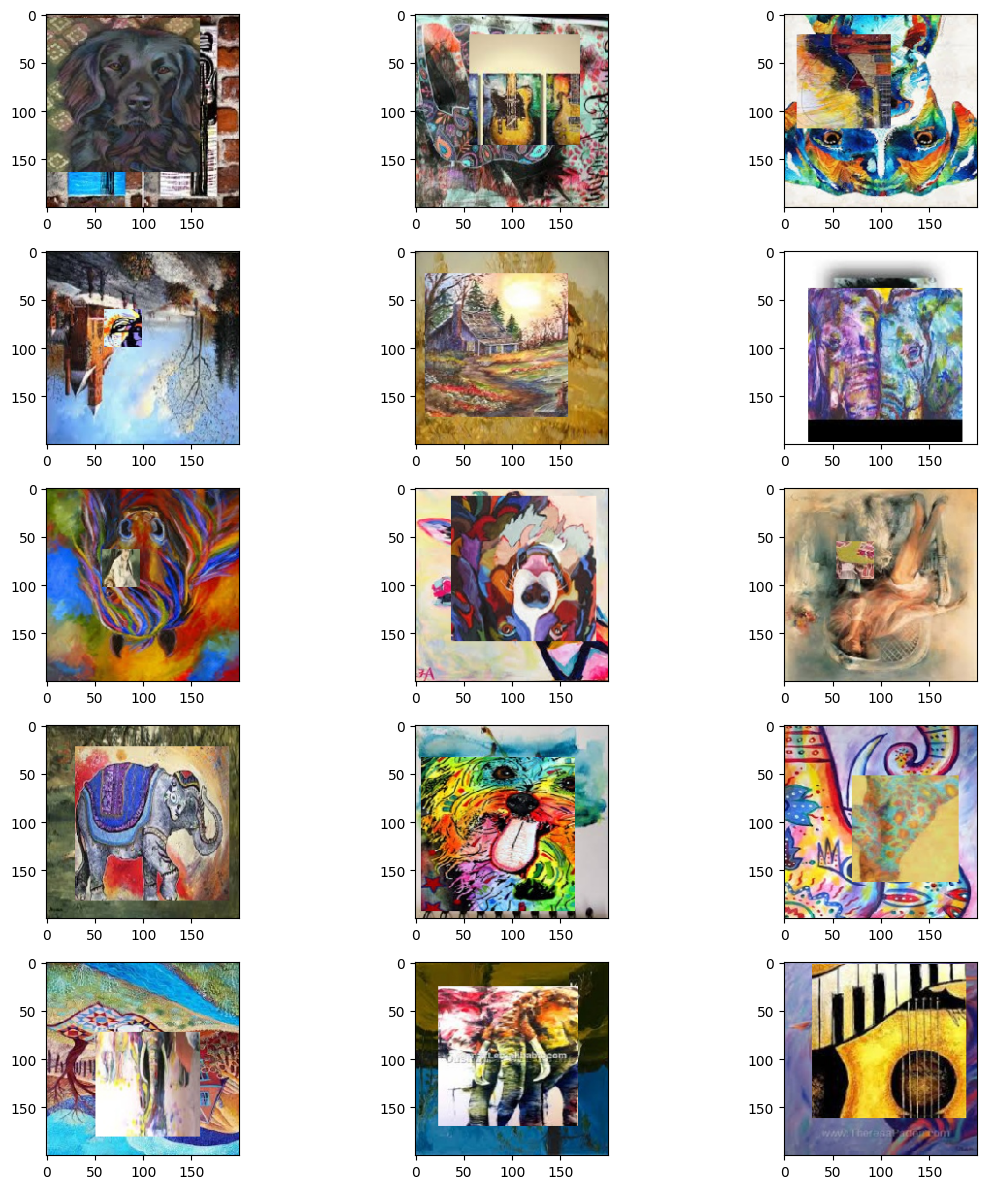

In [134]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in train_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [135]:
test_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = test_datagen.flow_from_dataframe(
    validation_df,
    train_dir,
    x_col='filename',
    y_col='category',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    color_mode=color_mode,
    class_mode='categorical',
)

Found 340 validated image filenames belonging to 7 classes.


In [136]:
validation_generator

## Model Settings

In [137]:
import os
from tensorflow.keras.applications import Xception  # (299 x 299)
from tensorflow.keras.applications import InceptionV3  # (299 x 299)
from tensorflow.keras.applications import InceptionResNetV2  # (299 x 299)
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.applications import DenseNet201

In [138]:
conv_bases = (
    EfficientNetB4, Xception, DenseNet201#EfficientNetB5#, InceptionV3, InceptionResNetV2
)

## Model Definition
- 모델의 경우 ImageNet 데이터 셋과 유사하다고 판단하여 pretrained model을 활용
- art 데이터셋이므로 모든 파라미터를 재학습시킴
- FCN의 파라미터가 많다는 단점을 개선시키기 위해서 Gloabal Averager Pooling을 활용
- 또한, GAP 사용시 input size를 유동적으로 사용할 수 있음

In [139]:
# Define Get Model Function
def get_model(pretained_model, img_size, channel_size, initializer, regularizer, optimizer, dropout_rate, class_nb):
    model = models.Sequential()
    model.add(
        pretained_model(
            include_top=False,
            weights='imagenet',
            input_shape=(img_size, img_size, channel_size)
        )
    )
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(
        512,
        activation='relu',
        kernel_initializer=initializer,
        kernel_regularizer=regularizer,
    ))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(class_nb, activation='softmax'))
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])
    return model

# Define Get Step Function
def get_steps(num_data, batch_size):
    quotient, remainder = divmod(num_data, batch_size)
    return (quotient + 1) if remainder else quotient

## Callback
- ReduceLROnPlateau : 학습률이 개선되지 않을 때, 동적으로 학습률을 조정하여 Local Minima에 빠지는 현상을 갯너
- EarlyStopping : model의 성능 지표가 설정한 epoch동안 개선되지 않을 때 조기 종료하기 위해서 사용
- ModelCheckpoint : weight의 최고 성능(val_loss가 min)의 경우 weight를 저장하기 위해서 사용

In [140]:
# 콜백 함수를 생성하는 함수 정의
def get_callback_list(model_file_path, patience, verbose, system_print=False):
    # 조기 종료(Early Stopping) 콜백을 정의합니다. 검증 손실(val_loss)이 개선되지 않을 때 학습을 멈추도록 설정합니다.
    early_stop = EarlyStopping(
        monitor='val_loss',    # 모니터링할 값
        patience=patience,     # 지정된 에폭 동안 개선이 없을 경우 학습을 중단
        verbose=verbose,       # 진행 상황을 출력할지 여부
        mode='min',            # 'val_loss'의 감소가 멈추면 중지
    )
    # 학습률을 점차 줄이는(Reduce Learning Rate on Plateau) 콜백을 정의합니다. 검증 손실이 개선되지 않을 때 학습률을 줄입니다.
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',   # 모니터링할 값
        factor=0.5,           # 학습률을 줄일 비율
        patience=patience//2, # 지정된 에폭의 절반 동안 개선이 없을 경우 학습률을 줄임
        verbose=verbose,      # 진행 상황을 출력할지 여부
        mode='min',           # 'val_loss'의 감소가 멈추면 학습률을 감소
        min_lr=1e-6,          # 학습률의 하한선
    )
    # 모델 체크포인트(Model Checkpoint) 콜백을 정의합니다. 검증 손실이 개선될 때마다 모델을 저장합니다.
    model_chk = ModelCheckpoint(
        filepath=model_file_path, # 모델을 저장할 파일 경로
        monitor='val_loss',       # 모니터링할 값
        verbose=verbose,          # 진행 상황을 출력할지 여부
        save_best_only=True,      # 가장 좋은 모델만 저장
        mode='min',               # 'val_loss'를 기준으로 최소값을 갖는 모델을 저장
    )
    # 콜백 리스트를 생성합니다.
    callback_list = [early_stop, reduce_lr, model_chk]
    # 시스템 로그를 출력하는 콜백이 필요한 경우 리스트에 추가합니다.
    if system_print:
        callback_list.append(PrintSystemLogPerEpoch())
    # 콜백 리스트를 반환합니다.
    return callback_list


In [141]:
# Constant Variables
LEARNING_RATE = 1e-4
OPTIMIZER = optimizers.Adam(learning_rate=LEARNING_RATE)
EPOCHS = 10
INITIALIZER = 'he_normal'
REGULARIZER = regularizers.l2(1e-3)
DROPOUT_RATE = 0.5
PATIENCE = 6  # Patience Value For Early Stop
VERBOSE = 1  # Verbosity mode (2: No progress bar)
CLASS_NB = len(classes) # The number of Classes

## Training
- 하이퍼파라미터 튜닝을 위해서 모델을 하나씩 돌려봄

In [142]:
num = 2
pretained_model = conv_bases[2]
MODEL_SAVE_FOLDER_PATH = './models/'
model_name = str(num) + '_' + str(pretained_model).split()[1]
model_path = MODEL_SAVE_FOLDER_PATH + model_name +'.h5'

GET_CLASS_WEIGHTS = False

print(model_name)

# Get Model
model = get_model(
    pretained_model=pretained_model,
    img_size=IMG_SIZE,
    channel_size=CHANNEL_SIZE,
    initializer=INITIALIZER,
    regularizer=REGULARIZER,
    optimizer=OPTIMIZER,
    dropout_rate=DROPOUT_RATE,
    class_nb=CLASS_NB,
)

# Train With Generators
history = model.fit_generator(
    generator=train_generator,
    steps_per_epoch=train_generator.get_steps_per_epoch(),
    epochs=EPOCHS,
    verbose=VERBOSE,
    callbacks=get_callback_list(
        model_file_path=model_path,
        patience=PATIENCE,
        verbose=VERBOSE,
        system_print=True,
    ),
    validation_data=validation_generator,
    validation_steps=get_steps(validation_generator.samples, BATCH_SIZE),
    class_weight=class_weights_dict if GET_CLASS_WEIGHTS else None,
    shuffle=False,
)

2_DenseNet201
* [Epoch 1] begins at 03:31:25.373238
Epoch 1/10


<ipython-input-142-9fd2cbb555a5>:24: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


68/68 [==============================] - ETA: 0s - loss: 2.6257 - acc: 0.4529
Epoch 1: val_loss improved from inf to 1.55930, saving model to ./models/2_DenseNet201.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


* [Epoch 1] ends at 03:33:54.724945 | acc=0.4529, val_acc=0.7794
68/68 [==============================] - 149s 498ms/step - loss: 2.6257 - acc: 0.4529 - val_loss: 1.5593 - val_acc: 0.7794 - lr: 1.0000e-04
* [Epoch 2] begins at 03:33:54.737244
Epoch 2/10
68/68 [==============================] - ETA: 0s - loss: 1.9874 - acc: 0.6929
Epoch 2: val_loss improved from 1.55930 to 1.12316, saving model to ./models/2_DenseNet201.h5
* [Epoch 2] ends at 03:34:19.918594 | acc=0.6929, val_acc=0.8882
68/68 [==============================] - 25s 370ms/step - loss: 1.9874 - acc: 0.6929 - val_loss: 1.1232 - val_acc: 0.8882 - lr: 1.0000e-04
* [Epoch 3] begins at 03:34:19.930399
Epoch 3/10
68/68 [==============================] - ETA: 0s - loss: 1.7906 - acc: 0.7216
Epoch 3: val_loss improved from 1.12316 to 0.98286, saving model to ./models/2_DenseNet201.h5
* [Epoch 3] ends at 03:34:45.194046 | acc=0.7216, val_acc=0.9176
68/68 [==============================] - 25s 372ms/step - loss: 1.7906 - acc: 0.7216

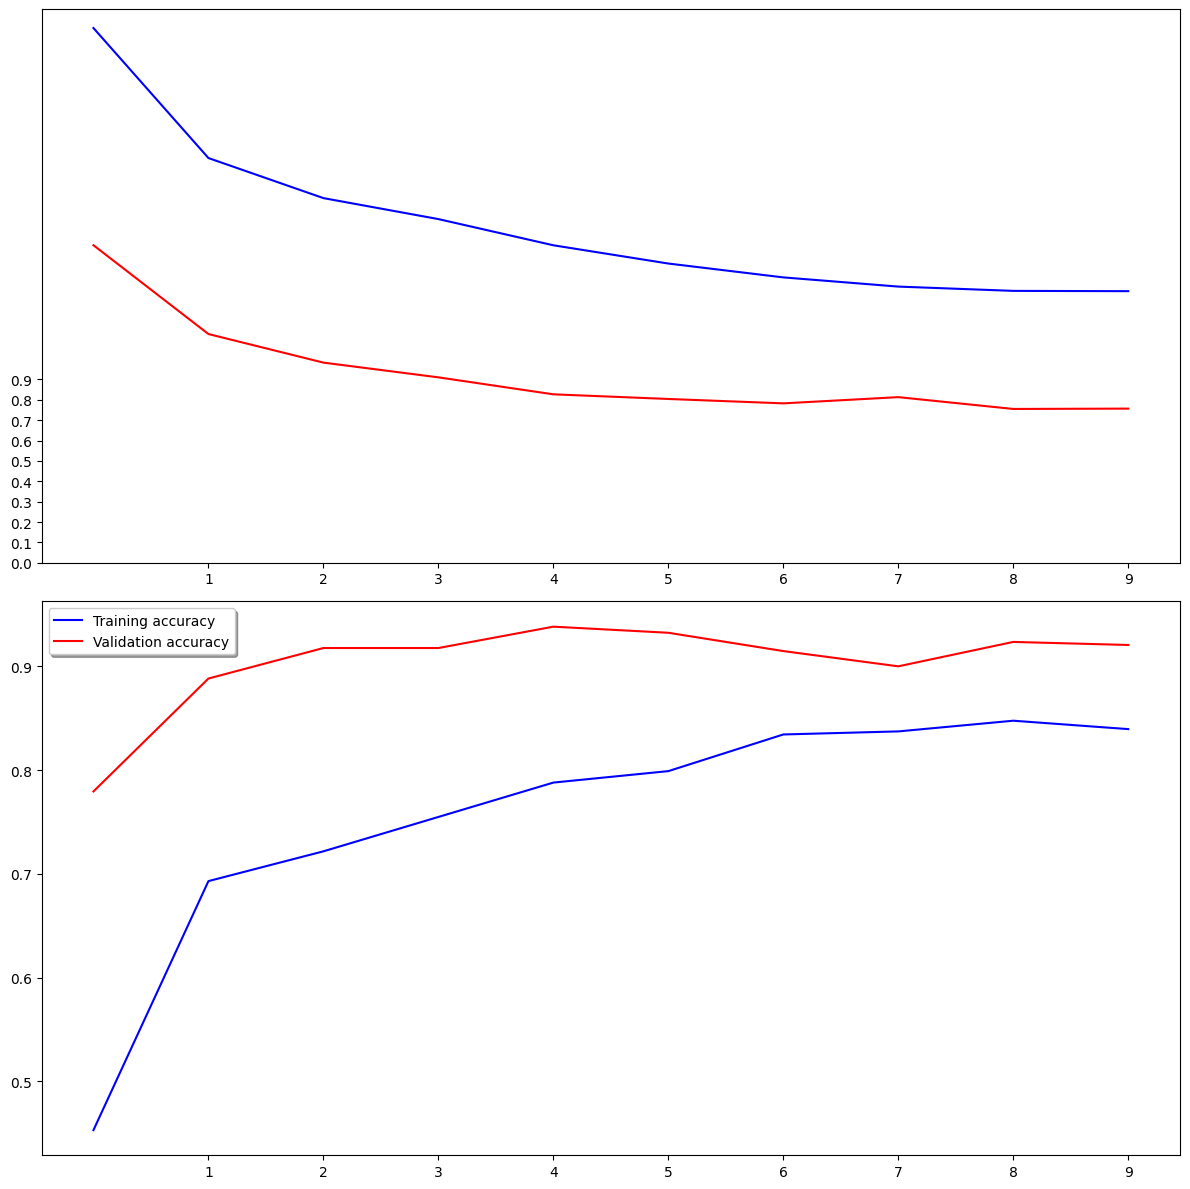

In [143]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, EPOCHS, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['acc'], color='b', label="Training accuracy")
ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, EPOCHS, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

## Retraining
- 기존에 학습시킨 EfficientNetB4, Xception을 재학습시킴
    - LEARNING_RATE = 1e-4 -> 1e-5
    - UnderSampling 적용
    - rotation_range=15, # 추가
    - shear_range=0.1, # 추가
    - zoom_range=0.2, # 추가

In [ ]:
historys = []

for i, conv_base in enumerate(conv_bases):

    num = i
    pretained_model = conv_base
    MODEL_SAVE_FOLDER_PATH = './models/'
    model_name = str(num) + '_' + str(pretained_model).split()[1]
    model_path = MODEL_SAVE_FOLDER_PATH + model_name +'.h5'

    GET_CLASS_WEIGHTS = False

    print(model_name)
    print("=====" * 10)

    # Get Model
    model = get_model(
        pretained_model=pretained_model,
        img_size=IMG_SIZE,
        channel_size=CHANNEL_SIZE,
        initializer=INITIALIZER,
        regularizer=REGULARIZER,
        optimizer=OPTIMIZER,
        dropout_rate=DROPOUT_RATE,
        class_nb=CLASS_NB,
    )

    model.load_weights(model_path)

    # Train With Generators
    history = model.fit_generator(
        generator=train_generator,
        steps_per_epoch=train_generator.get_steps_per_epoch(),
        epochs=EPOCHS,
        verbose=VERBOSE,
        callbacks=get_callback_list(
            model_file_path=model_path,
            patience=PATIENCE,
            verbose=VERBOSE,
            system_print=True,
        ),
        validation_data=validation_generator,
        validation_steps=get_steps(validation_generator.samples, BATCH_SIZE),
        class_weight=class_weights_dict if GET_CLASS_WEIGHTS else None,
        shuffle=False,
    )

    historys.append(history)

    model_finish_path = MODEL_SAVE_FOLDER_PATH + model_name +'_finish.h5'
    model.save_weights(model_finish_path)

0_EfficientNetB4


C:\Users\bsy37\anaconda3\envs\tensorflow24\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
* [Epoch 1] begins at 17:26:45.820542
85/85 [==============================] - 89s 766ms/step - loss: 1.0707 - acc: 0.8309 - val_loss: 1.0305 - val_acc: 0.7235

Epoch 00001: val_loss improved from inf to 1.03055, saving model to ./models\0_EfficientNetB4.h5
* [Epoch 1] ends at 17:28:16.188898 | acc=0.8298, val_acc=0.7235
Epoch 2/10
* [Epoch 2] begins at 17:28:16.218600
85/85 [==============================] - 59s 694ms/step - loss: 1.0454 - acc: 0.8243 - val_loss: 0.4863 - val_acc: 0.9412

Epoch 00002: val_loss improved from 1.03055 to 0.48631, saving model to ./models\0_EfficientNetB4.h5
* [Epoch 2] ends at 17:29:16.504430 | acc=0.8286, val_acc=0.9412
Epoch 3/10
* [Epoch 3] begins at 17:29:16.532453
85/85 [==============================] - 59s 695ms/step - loss: 1.0045 - acc: 0.8531 - val_loss: 0.4203 - val_acc: 0.9529

Epoch 00003: val_loss improved from 0.48631 to 0.42032, saving model to ./models\0_EfficientNetB4.h5
* [Epoch 3] ends at 17:30:16.925262 | acc=0.8386, val_a

In [ ]:
hist = historys[1]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(hist.history['loss'], color='b', label="Training loss")
ax1.plot(hist.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, EPOCHS, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(hist.history['acc'], color='b', label="Training accuracy")
ax2.plot(hist.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, EPOCHS, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

## Prediction
- 단일 모델 prediction과 앙상블 모델 preduiction 구현
- prediction 결과에 person이 많이 존재하는 것으로 보아, class imbalance가 있음을 유추할 수 있음
- class imbalance문제를 해결하기 위해 undersampling 적용

In [89]:
test_dir = os.path.join(base_dir, 'test/0')
print(test_dir)
test_filenames = os.listdir(test_dir)
print(test_filenames)
test_df = pd.DataFrame({
    'filename': test_filenames
})


/content/test/0
['0287.jpg', '0030.jpg', '0090.jpg', '0048.jpg', '0227.jpg', '0109.jpg', '0024.jpg', '0108.jpg', '0120.jpg', '0247.jpg', '0130.jpg', '0122.jpg', '0280.jpg', '0239.jpg', '0209.jpg', '0272.jpg', '0134.jpg', '0082.jpg', '0176.jpg', '0116.jpg', '0052.jpg', '0323.jpg', '0286.jpg', '0028.jpg', '0029.jpg', '0316.jpg', '0126.jpg', '0271.jpg', '0132.jpg', '0175.jpg', '0001.jpg', '0141.jpg', '0328.jpg', '0303.jpg', '0232.jpg', '0268.jpg', '0064.jpg', '0027.jpg', '0172.jpg', '0118.jpg', '0181.jpg', '0237.jpg', '0182.jpg', '0170.jpg', '0188.jpg', '0014.jpg', '0045.jpg', '0178.jpg', '0202.jpg', '0208.jpg', '0225.jpg', '0299.jpg', '0264.jpg', '0281.jpg', '0292.jpg', '0205.jpg', '0234.jpg', '0146.jpg', '0101.jpg', '0338.jpg', '0336.jpg', '0063.jpg', '0144.jpg', '0171.jpg', '0230.jpg', '0243.jpg', '0191.jpg', '0173.jpg', '0049.jpg', '0115.jpg', '0300.jpg', '0135.jpg', '0160.jpg', '0095.jpg', '0340.jpg', '0184.jpg', '0220.jpg', '0308.jpg', '0050.jpg', '0039.jpg', '0274.jpg', '0145.jpg',

In [90]:
test_df

filename
0    0287.jpg
1    0030.jpg
2    0090.jpg
3    0048.jpg
4    0227.jpg
..        ...
345  0114.jpg
346  0337.jpg
347  0223.jpg
348  0265.jpg
349  0047.jpg

[350 rows x 1 columns]

In [91]:

nb_samples = test_df.shape[0]

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    test_dir,
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    color_mode=color_mode,
    shuffle=False
)

Found 350 validated image filenames.


In [ ]:
ENSEMBLE = False

model_paths = MODEL_SAVE_FOLDER_PATH

if ENSEMBLE:
    model_preds = []

    for i, conv_base in enumerate(conv_bases):

        num = i
        pretained_model = conv_base
        MODEL_SAVE_FOLDER_PATH = './models/'
        model_name = str(num) + '_' + str(pretained_model).split()[1]
        model_path = MODEL_SAVE_FOLDER_PATH + model_name +'.h5'

        # Get Model
        model = get_model(
            pretained_model=pretained_model,
            img_size=IMG_SIZE,
            channel_size=CHANNEL_SIZE,
            initializer=INITIALIZER,
            regularizer=REGULARIZER,
            optimizer=OPTIMIZER,
            dropout_rate=DROPOUT_RATE,
            class_nb=CLASS_NB,
        )

        model.load_weights(model_path)

        test_generator.reset()
        pred = model.predict_generator(
            test_generator,
            #steps=np.ceil(nb_samples/batch_size),
            steps=get_steps(test_df.shape[0], BATCH_SIZE),
            verbose=VERBOSE)

        model_preds.append(pred)

pred_mean = np.mean(model_preds, axis=0)
test_df['category'] = np.argmax(pred_mean, axis=1)

label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [93]:
if not ENSEMBLE:
    # Prediction
    print(model_path)
    model.load_weights(model_path)
    pred = model.predict_generator(
        test_generator,
        #steps=np.ceil(nb_samples/batch_size),
        steps=get_steps(test_df.shape[0], BATCH_SIZE),
        verbose=VERBOSE)

    test_df['category'] = np.argmax(pred, axis=1)

    label_map = dict((v,k) for k,v in train_generator.class_indices.items())
    test_df['category'] = test_df['category'].replace(label_map)

./models/2_DenseNet201.h5


<ipython-input-93-4729347ad915>:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred = model.predict_generator(


18/18 [==============================] - 5s 79ms/step


In [103]:
# 제공된 딕셔너리
category_to_num = {
    0: 'dog',
    1: 'elephant',
    2: 'giraffe',
    3: 'guitar',
    4: 'horse',
    5: 'house',
    6: 'person'
}

# 키와 값의 위치를 바꾼 새로운 딕셔너리 생성
num_to_category = {value: key for key, value in category_to_num.items()}

# validate_df의 'category' 열에 딕셔너리를 적용하여 카테고리 이름을 숫자로 변환
validate_df['category'] = validate_df['category'].map(num_to_category)
validate_df['category']

553     4
1385    5
415     6
1662    6
1456    1
       ..
1454    2
1591    5
1363    5
122     2
571     3
Name: category, Length: 170, dtype: int64

In [105]:
y_pred

array([2, 0, 5, 4, 0, 4, 6, 2, 0, 5, 4, 0, 3, 0, 5, 5, 6, 6, 5, 0, 3, 5,
       6, 6, 4, 2, 5, 6, 6, 0, 6, 0, 0, 1, 5, 6, 2, 2, 2, 2, 1, 5, 2, 6,
       6, 0, 0, 4, 1, 6, 4, 5, 6, 6, 5, 0, 2, 2, 3, 6, 5, 1, 6, 1, 0, 2,
       0, 6, 1, 4, 3, 3, 1, 2, 1, 5, 6, 1, 0, 5, 6, 3, 6, 6, 5, 1, 0, 4,
       2, 6, 6, 5, 2, 5, 5, 4, 6, 6, 3, 1, 6, 0, 2, 0, 2, 1, 6, 1, 4, 6,
       6, 6, 4, 0, 2, 4, 6, 3, 2, 6, 6, 0, 2, 0, 4, 0, 6, 4, 1, 5, 6, 0,
       5, 0, 2, 5, 3, 2, 1, 5, 5, 5, 6, 0, 6, 4, 3, 1, 6, 1, 6, 2, 3, 6,
       0, 0, 2, 2, 5, 1, 0, 0, 3, 0, 0, 0, 1, 0, 1, 3])

In [107]:
y_valid = np.array(validate_df['category'])
y_valid

array([4, 5, 6, 6, 1, 1, 6, 0, 2, 0, 4, 2, 0, 5, 3, 4, 4, 1, 3, 6, 3, 6,
       0, 0, 0, 6, 6, 4, 2, 1, 6, 2, 2, 4, 6, 5, 0, 6, 6, 1, 0, 0, 6, 2,
       3, 5, 6, 6, 5, 2, 1, 6, 6, 4, 5, 5, 5, 6, 2, 3, 0, 1, 1, 2, 0, 1,
       3, 6, 0, 6, 6, 4, 6, 0, 0, 0, 6, 6, 6, 2, 2, 1, 6, 5, 3, 6, 5, 0,
       4, 1, 5, 0, 2, 5, 0, 5, 5, 2, 6, 5, 0, 0, 6, 2, 6, 2, 2, 4, 0, 2,
       0, 6, 6, 0, 5, 6, 4, 5, 6, 1, 0, 5, 6, 4, 5, 1, 0, 4, 2, 3, 3, 3,
       4, 0, 4, 3, 6, 0, 5, 2, 2, 0, 5, 0, 1, 1, 5, 2, 6, 6, 0, 6, 1, 6,
       2, 1, 0, 6, 0, 1, 1, 1, 3, 0, 5, 2, 5, 5, 2, 3])

In [109]:
model.load_weights(model_path)
y_pred = model.predict()
y_pred = np.argmax(y_pred, axis=1)
y_valid = np.array(validate_df['category'])


from sklearn.metrics import f1_score, accuracy_score

# 실제 레이블과 예측 레이블


# F1 Score 계산
f1 = f1_score(y_valid, y_pred, average='weighted')  # 'weighted'는 클래스 불균형을 고려합니다

# Accuracy 계산
accuracy = accuracy_score(y_valid, y_pred)

# 결과 출력
print("F1 Score:", f1)
print("Accuracy:", accuracy)


1/9 [==>...........................] - ETA: 0s

<ipython-input-109-4b4921580904>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = model.predict_generator(


9/9 [==============================] - 1s 86ms/step
F1 Score: 0.11176470588235295
Accuracy: 0.11176470588235295


<Axes: >

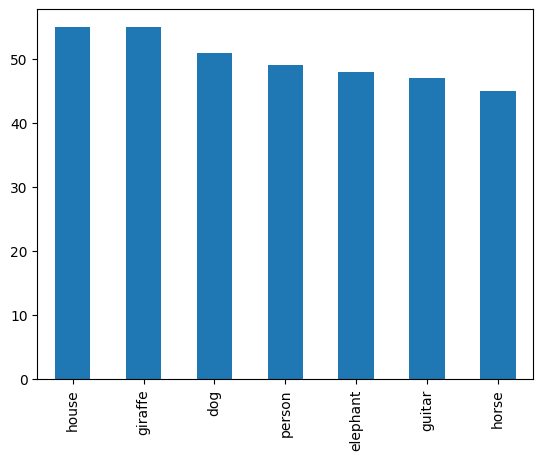

In [94]:
test_df['category'].value_counts().plot.bar()

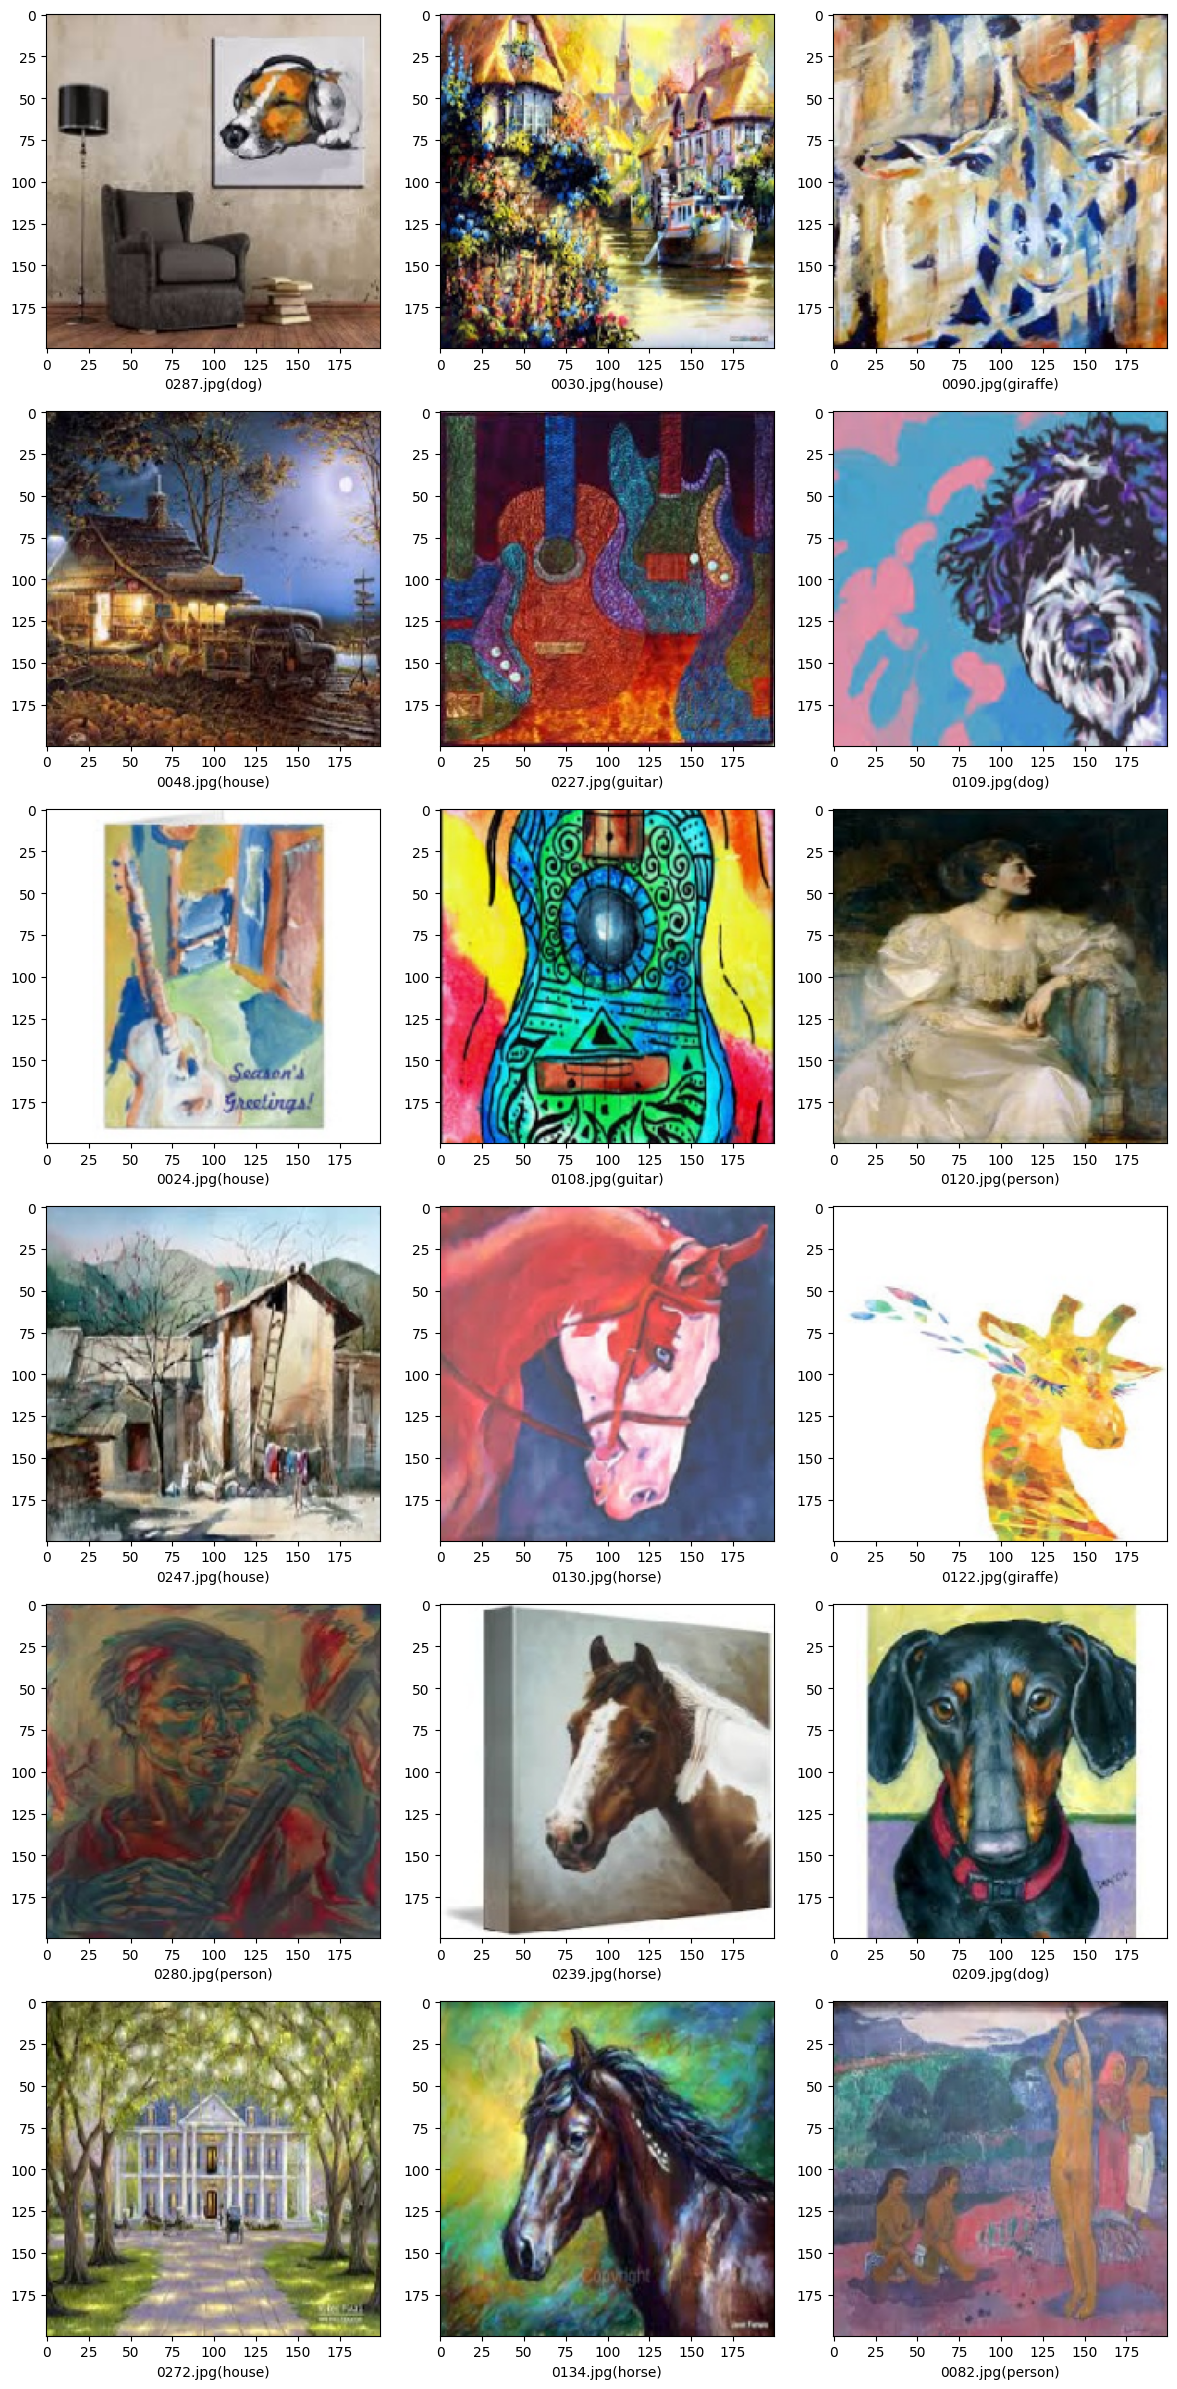

In [95]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img(test_dir + "/" + filename, target_size=(IMG_SIZE,IMG_SIZE))
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

## Submission

In [96]:
classes_test_dict = {c : i for i,c in enumerate(classes)}

In [97]:
test_df['category'] = test_df['category'].replace(classes_test_dict)

In [98]:
submission_df = test_df.copy()
submission_df['answer value'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=True)

In [99]:
submission_df

answer value
0               0
1               5
2               2
3               5
4               3
..            ...
345             5
346             4
347             2
348             1
349             0

[350 rows x 1 columns]